# Parameter sensitivity

Analysis of the effect of parameter changes on the output of standard simulations. The single cell clearance model of galactose metabolism is tested.

In [1]:
# notebook setup
from __future__ import print_function, division
%matplotlib inline

In [2]:
# simulation & model database
import django
django.setup()
# import the database API functions and tools
import simapp.db.api as db_api
import multiscale.odesim.db.tools as db_tools

In [7]:
# create model in database
from multiscale.examples.testdata import galactose_singlecell_sbml
print(galactose_singlecell_sbml)
comp_model = db_api.create_model(filepath=galactose_singlecell_sbml)

/home/mkoenig/git/multiscale-galactose/python/multiscalepy/multiscale/examples/models/galactose/galactose_29_annotated.xml


In [8]:
# TODO: fix how to get models !
if not comp_model:
    from simapp.models import CompModel
    comp_models = CompModel.objects.filter(model_id="galactose_29_annotated")
    comp_model = comp_models[0]
    print(comp_model)

<SBML: galactose_29_annotated>


In [9]:
import roadrunner
reload(roadrunner)
print(roadrunner.getVersionStr())

1.4.2; Compiler: gcc 4.8.4, C++ version: 199711; JIT Compiler: LLVM-3.4; Date: Jan 12 2016, 10:04:24


## Reference simulation
Reference simulation against which the parameter changes are tested.

Loading : /home/mkoenig/multiscale-galactose-results/django/model/galactose_29_annotated.xml
SBML load time: 0.600586891174
********************************************************************************
['time', '[c__ppi]', '[e__h2oM]', '[c__glc1p]', '[c__udpgal]', '[c__udp]', '[c__atp]', '[c__utp]', '[e__gal]', '[c__gal1pM]', '[c__gal]', '[c__galtolM]', '[e__galM]', '[c__glc6p]', '[c__adp]', '[h__h2oM]', '[c__nadp]', '[c__udpgalM]', '[c__galM]', '[c__galtol]', '[c__nadph]', '[c__glc6pM]', '[c__glc1pM]', '[c__udpglc]', '[c__gal1p]', '[c__udpglcM]', '[c__phos]']
********************************************************************************
********************************************************************************
<roadrunner.RoadRunner() { 
'this' : 0x1c2c84d0
'modelLoaded' : true
'modelName' : galactose_29
'libSBMLVersion' : LibSBML Version: 5.11.0
'jacobianStepSize' : 1e-05
'conservedMoietyAnalysis' : false
'simulateOptions' : 
< roadrunner.SimulateOptions() 
{ 
'this' : 0x1

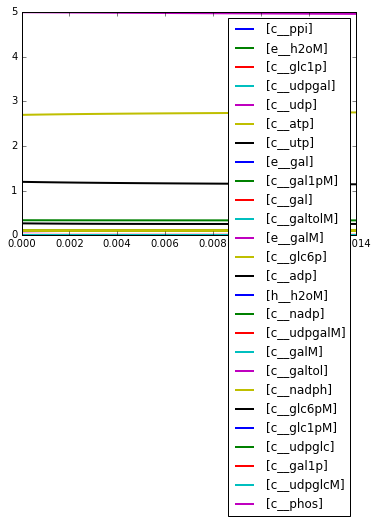

tend: 0.013943530262


NameError: name 'store_concentrations' is not defined

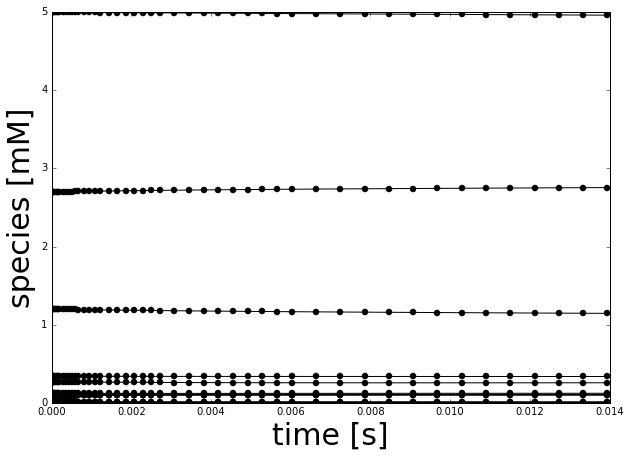

In [24]:
# standard simulation 
import multiscale.odesim.simulate.roadrunner_tools as rt
reload(rt)
r = rt.load_model(comp_model.filepath)

# selections
r.selections = ['time'] + ['[{}]'.format(s) for s in r.model.getFloatingSpeciesIds()]
print('*'*80)
print(r.selections)
print('*'*80)

# settings
rt.set_integrator_settings(r)
# simulate
s, _ = rt.simulate(r, 0, 1000)
r.plot()
rt.plot_results([s])

# store the final concentrations
c1 = store_concentrations(r)

In [ ]:
# TODO:

# what should be simulated?
# Typical galactose challenge after certain amount of time.
# What are the effects of parameter changes in the model (analysis of variability)

# TODO


# Changed fixed boundary conditions
r.reset(SelectionRecord.ALL)  # reset model

# storage for partial results
results = []
tends = [20, 50, 70]
Nsim = 10

for k in xrange(Nsim):
    # simulate & store concentrations at end point
    s1 = r.simulate(0, tends[0])
    c1 = store_concentrations(r)

    # change boundary concentrations
    e__gal = r.e__gal  # store old value
    r.e__gal = k+1       # set new value
    s2 = r.simulate(tends[0], tends[1])
    
    # reset values
    r.e__gal = e__gal  # restore value
    s3 = r.simulate(tends[1], tends[2])
    
    s = np.concatenate([s1, s2, s3], axis=0)
    results.append(s)

# plot the results
plot_results(results)

### Full Tissue model
Incorporated single cell model in the tissue model.

In [22]:
import multiscale.examples.testdata as testdata
reload(testdata)
print(testdata.galactose_tissue_sbml)
reload(rt)
# 31s, reload 2.7s (core), 
r = rt.load_model(testdata.galactose_tissue_sbml)
s = rt.simulate(r, 0, 10000)

/home/mkoenig/git/multiscale-galactose/python/multiscalepy/multiscale/examples/models/galactose/Galactose_v128_Nc20_dilution.xml
Loading : /home/mkoenig/git/multiscale-galactose/python/multiscalepy/multiscale/examples/models/galactose/Galactose_v128_Nc20_dilution.xml
SBML load time: 32.5358040333
Integration time: 1.66125512123


In [ ]:
r.plot()

In [ ]:
from roadrunner import SelectionRecord


In [ ]:
# TODO: series of simulations
# s2 = roadrunner_tools.simulate(r, 0, 1000, reset=False)
# s2 = roadrunner_tools.simulate(r, 0, 10, reset=False)
# s2 = roadrunner_tools.simulate(r, 0, 10, reset=False)
mtest = CompModel.objects.get(model_id="test_1")
print(mtest)
reload(roadrunner)
r = roadrunner.RoadRunner(mtest.filepath)
r.simulate(0,10, plot=True)
??r.simulate
print(r)
rt.print_integrator_settings(r)


## Parameter variability analysis

Vary all single parameters in the model between [0.95-1.05] the original value.

In [ ]:
# These are the parameters to vary
parameter_ids = rr.model.getGlobalParameterIds()
parameter_ids

In [ ]:
# get units from the sbml
import libsbml
doc = libsbml.readSBML(demo_filepath)
sbml_model = doc.getModel()
units = {}
for pid in parameter_ids: 
    p = sbml_model.getParameter(pid)
    unit = p.getUnits()
    units[pid] = unit
units

In [ ]:
# get the original values for all parameters
values = {pid: rr[pid] for pid in parameter_ids}
values

In [ ]:
# now we can setup the single variations
from multiscale.odesim.dist.samples import Sample, SampleParameter
factors = [0.90, 1.10]
samples = []
for pid in parameter_ids:
    for f in factors:
        # create an empty sample
        s = Sample()
        # Set the parameters to the values
        sp = SampleParameter(pid, f * rr[pid], unit=units[pid], \
                             parameter_type=db_api.ParameterType.GLOBAL_PARAMETER)
        s.add_parameter(sp)
        samples.append(s)

samples

In [ ]:
# We want step based integration in the interval [0.0, 20.0]
settings_dict = {db_api.SettingKey.VAR_STEPS: False,\
                 db_api.SettingKey.T_START: 0.0,\
                 db_api.SettingKey.T_END: 20.0, \
                 db_api.SettingKey.STEPS: 100}

# For the tolerances, ... we use the default settings
settings = db_api.create_settings(settings_dict)
for setting in settings:
    print(setting)

In [ ]:
method = db_api.create_method(method_type=db_api.MethodType.ODE, settings=settings)

In [ ]:
task = db_api.create_task(comp_model, method=method, info="Single parameter variation {}.".format(factors))

In [ ]:
from django.core.exceptions import ValidationError
try:
    # add the simulations to the task
    simulations = db_tools.create_simulations_from_samples(task, samples)
    # finalize task, so no additional simulations can be added
    task.finalize_status()
except ValidationError:
    simulations = task.simulations.all()
simulations
print('TaskStatus:', task.status_str)

In [ ]:
len(simulations)

### Solve the ODE system

Now we are running the solver on the defined problems.

In [ ]:
from multiscale.odesim.simulate import solve

In [ ]:
solve.run_simulations(simulations, task)

In [ ]:
# plot the results
from simapp.models import Result
import matplotlib.pylab as plt
plt_fontsize = 30

In [ ]:
# Load the HDF5 files and plot them
from multiscale.odesim.simulate import solve_io
reload(solve_io)
plt.figure(figsize=(20,14))
for sim in simulations:
    result = Result.objects.get(simulation=sim, result_type=db_api.ResultType.HDF5)
    data, header = solve_io.load_hdf5(result.filepath)
    plt.plot(data[:,0], data[:,1:], '-', color='black')
    
plt.xlabel('time [s]', fontsize=plt_fontsize)
plt.ylabel('species [mM]', fontsize=plt_fontsize);

## Double parameter variation

For comparison all double parameter changes in the model are performed.  
How much larger are the combined effects of parameter changes?

In [ ]:
# now we can setup the double variations
from multiscale.odesim.dist.samples import Sample, SampleParameter
samples_double = []
for pid1 in parameter_ids:
    for pid2 in parameter_ids:
        if pid1 == pid2:
            continue
        for f1 in factors:
            for f2 in factors:
        
                # create an empty sample
                s = Sample()
                # Set first parameter
                sp1 = SampleParameter(pid1, f1 * rr[pid1], unit=units[pid1], \
                             parameter_type=db_api.ParameterType.GLOBAL_PARAMETER)
                # Set second parameter
                sp2 = SampleParameter(pid2, f2 * rr[pid2], unit=units[pid2], \
                             parameter_type=db_api.ParameterType.GLOBAL_PARAMETER)
                s.add_parameters([sp1, sp2])
                samples_double.append(s)
print('Number of parameters:', len(parameter_ids))                
print('Number of samples:', len(samples_double))

In [ ]:
task_double = db_api.create_task(comp_model, method=method, info="Double parameter variation {}.".format(factors))

In [ ]:
# Removing objects from the database
# from simapp.models import Task
# task_temp = Task.objects.get(pk=64)
# task_temp.delete()
# task_double.info = "Double parameter variation {}.".format(factors)
# task_double.save()

In [ ]:
print('TaskStatus:', task.status_str)
from django.core.exceptions import ValidationError
try:
    # add the simulations to the task
    simulations_double = db_tools.create_simulations_from_samples(task_double, samples_double)
    # finalize task, so no additional simulations can be added
    task_double.finalize_status()
except ValidationError:
    simulations_double = task_double.simulations.all()
simulations
print('TaskStatus:', task.status_str)

In [ ]:
import time
start = time.time()
solve.run_simulations(simulations_double, task_double)
duration = time.time() - start
print('Total time:', duration)

In [ ]:
# Load the HDF5 files and plot them
from multiscale.odesim.simulate import solve_io
reload(solve_io)
plt.figure(figsize=(20,14))
for sim in simulations_double:
    result = Result.objects.get(simulation=sim, result_type=db_api.ResultType.HDF5)
    data, header = solve_io.load_hdf5(result.filepath)
    plt.plot(data[:,0], data[:,1:], '-', color='grey')
    
for sim in simulations:
    result = Result.objects.get(simulation=sim, result_type=db_api.ResultType.HDF5)
    data, header = solve_io.load_hdf5(result.filepath)
    plt.plot(data[:,0], data[:,1:], '-', color='black')
    
plt.xlabel('time [s]', fontsize=plt_fontsize)
plt.ylabel('species [mM]', fontsize=plt_fontsize)